In [21]:
import json
import matplotlib.pyplot as plt
import networkx as nx

with open("safaris_30_items_enhanced.json", "r", encoding="utf-8") as f:
    tours = json.load(f)

In [22]:
def parse_coordinate(coord_str):
    """
    Converts '7.15° N' or '79.85° E' to float values: 7.15 or 79.85
    Assumes N and E are positive, S and W are negative.
    """
    if not isinstance(coord_str, str):
        return float(coord_str)  # already numeric

    coord_str = coord_str.strip().replace("°", "")
    if "N" in coord_str or "E" in coord_str:
        return float(coord_str.replace("N", "").replace("E", "").strip())
    elif "S" in coord_str or "W" in coord_str:
        return -float(coord_str.replace("S", "").replace("W", "").strip())
    else:
        return float(coord_str.strip())  # fallback

In [23]:
from geopy.distance import geodesic

def find_safaris_near_location(user_text, data):
    user_location = "Gampaha"
    user_coords = (7.15, 79.85)

    results = []

    for item in data:
        features = item.get("extracted_features", {})
        if "latitude" not in features or "longitude" not in features:
            continue  # skip if missing coords

        try:
            lat = parse_coordinate(features["latitude"])
            lon = parse_coordinate(features["longitude"])
        except:
            continue  # skip on bad format

        safari_coords = (lat, lon)
        distance = geodesic(user_coords, safari_coords).km

        if features.get("district", "").lower() == user_location.lower() or distance <= 50:
            item["distance_km"] = round(distance, 2)
            results.append(item)

    sorted_results = sorted(results, key=lambda x: (-float(x.get("rating", 0)), x["distance_km"]))
    return sorted_results

In [24]:
user_query = "near Ratnapura"
matching_tours = find_safaris_near_location(user_query, tours)

# Make it into a roadmap
roadmap = matching_tours[:5]  # take top 5 for now


In [25]:
import networkx as nx
import matplotlib.pyplot as plt

def visualize_roadmap_graph(roadmap):
    if not roadmap:
        print("🚫 No roadmap to display.")
        return

    G = nx.DiGraph()

    labels = {}
    for idx, item in enumerate(roadmap):
        title = item["title"]
        park = item["extracted_features"]["park_names"][0] if item["extracted_features"].get("park_names") else "Unknown"
        label = f"{idx+1}. {park}\n⭐{item.get('rating', '?')}"
        G.add_node(title)
        labels[title] = label

    # Add edges to form a path
    for i in range(len(roadmap) - 1):
        G.add_edge(roadmap[i]["title"], roadmap[i+1]["title"])

    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(14, 8))
    nx.draw_networkx_nodes(G, pos, node_size=2500)
    nx.draw_networkx_edges(G, pos, arrows=True, arrowsize=20, connectionstyle='arc3,rad=0.2')
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=9)

    plt.title("🗺️ Safari Tour Roadmap (Graph View)", fontsize=14)
    plt.axis("off")
    plt.tight_layout()
    plt.show()


C:\Users\thara\AppData\Local\Temp\ipykernel_26504\1051134699.py:31: UserWarning: Glyph 128506 (\N{WORLD MAP}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
d:\Projects\Project-RoadmapGenerationModel\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Projects\Project-RoadmapGenerationModel\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128506 (\N{WORLD MAP}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


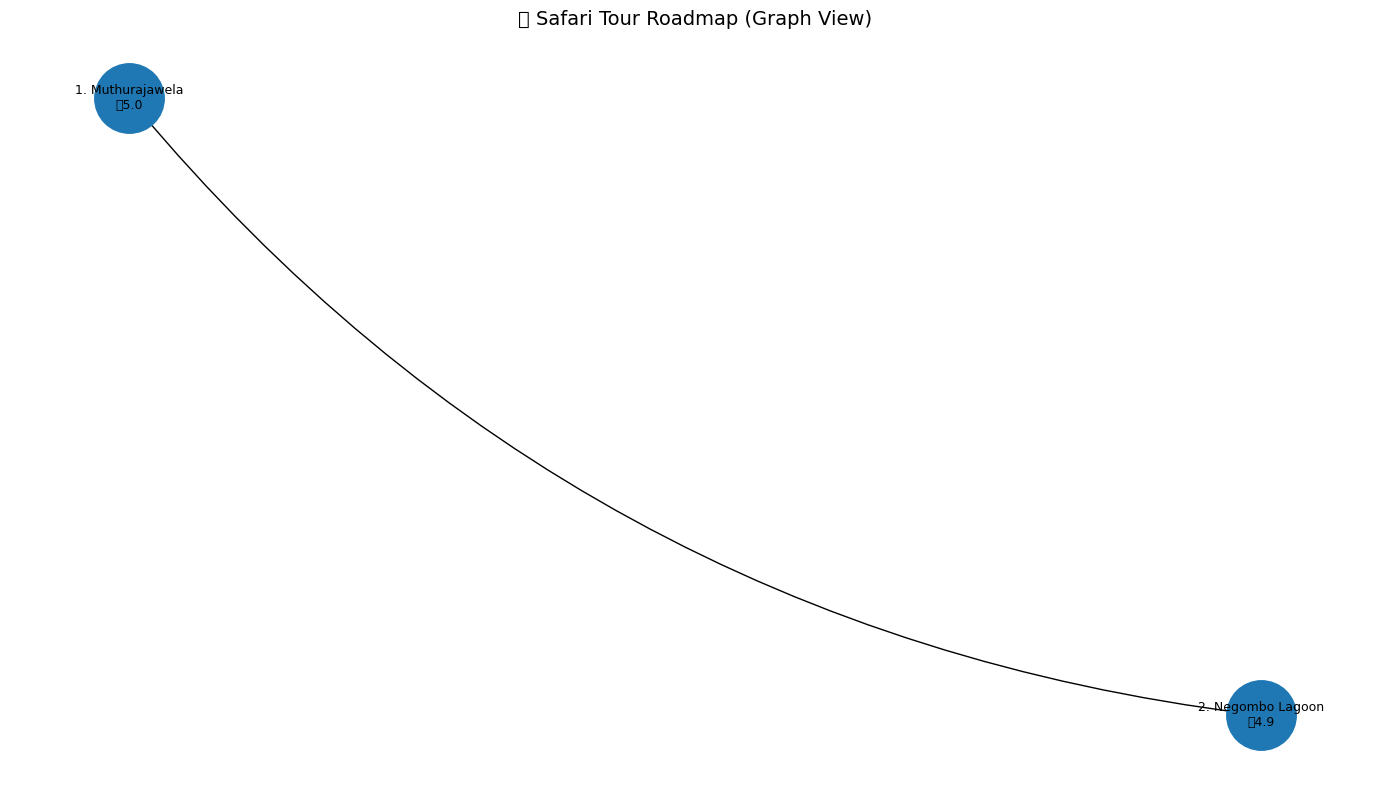

In [26]:
visualize_roadmap_graph(roadmap)
